## BYOL (Bootstrap Your Own Latent)
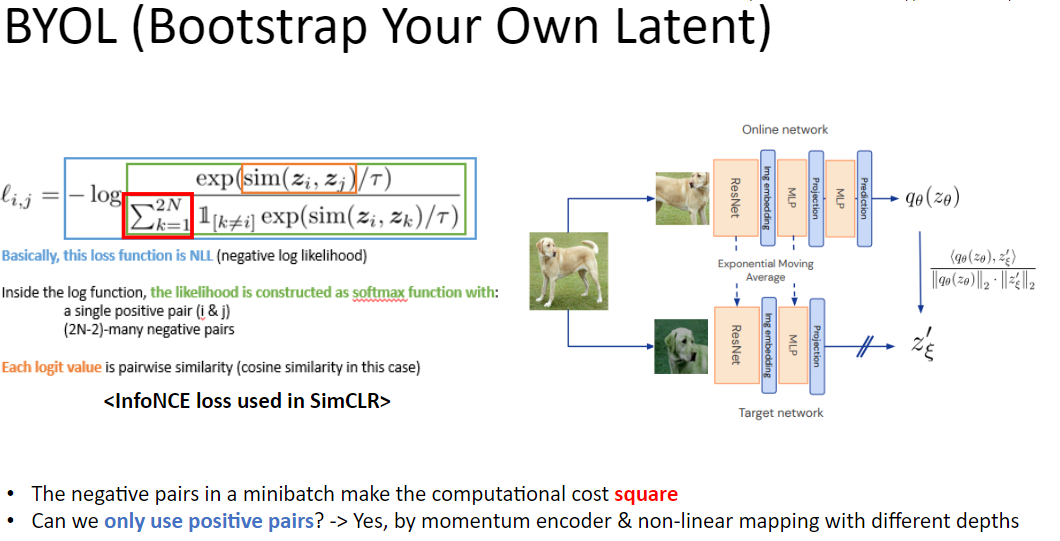  

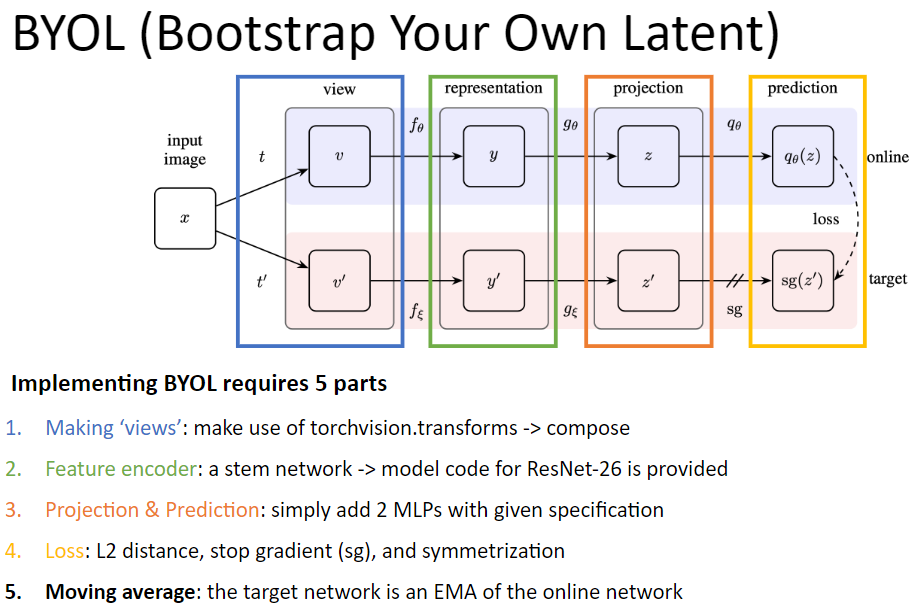

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import numpy as np
import os
import copy
import time

### Step 1. Design BYOL Model & Loss

#### Implementation 1-1. Create modules

#### Implementation 1-2. Design BYOL loss function

#### Implementation 1-3. Design forward function

In [2]:
import math
from torchvision.models.resnet import conv3x3


class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, norm_layer, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.downsample = downsample
        self.stride = stride

        self.bn1 = norm_layer(inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)

        self.bn2 = norm_layer(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        residual = x
        residual = self.bn1(residual)
        residual = self.relu1(residual)
        residual = self.conv1(residual)

        residual = self.bn2(residual)
        residual = self.relu2(residual)
        residual = self.conv2(residual)

        if self.downsample is not None:
            x = self.downsample(x)
        return x + residual


class Downsample(nn.Module):
    def __init__(self, nIn, nOut, stride):
        super(Downsample, self).__init__()
        self.avg = nn.AvgPool2d(stride)
        assert nOut % nIn == 0
        self.expand_ratio = nOut // nIn

    def forward(self, x):
        x = self.avg(x)
        return torch.cat([x] + [x.mul(0)] * (self.expand_ratio - 1), 1)


class ResNetCifar(nn.Module):
    def __init__(self, depth=26, width=1, channels=3, norm_layer=nn.BatchNorm2d):
        assert (depth - 2) % 6 == 0         # depth is 6N+2
        self.N = (depth - 2) // 6
        super(ResNetCifar, self).__init__()

        # Following the Wide ResNet convention, we fix the very first convolution
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.inplanes = 16
        self.layer1 = self._make_layer(norm_layer, 16 * width)
        self.layer2 = self._make_layer(norm_layer, 32 * width, stride=2)
        self.layer3 = self._make_layer(norm_layer, 64 * width, stride=2)
        self.bn = norm_layer(64 * width)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(8)

        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

    def _make_layer(self, norm_layer, planes, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = Downsample(self.inplanes, planes, stride)
        layers = [BasicBlock(self.inplanes, planes, norm_layer, stride, downsample)]
        self.inplanes = planes
        for i in range(self.N - 1):
            layers.append(BasicBlock(self.inplanes, planes, norm_layer))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x


class MLP(nn.Module):
    def __init__(self, idim, hdim, odim, width=1.):
        super().__init__()

        self.fc1 = nn.Linear(idim * width, hdim * width)
        self.bn1 = nn.BatchNorm1d(hdim * width)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hdim * width, odim * width)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x


class BYOLNet(nn.Module):
    def __init__(self,
                 width=1,
                 feat_dim=64,
                 hidden_dim=128,
                 byol_feat_dim=32,
                 num_classes=10):
        super().__init__()

        ### IMPLEMENTATION 1-1 ###
        # f: convolutional feature encoder, use ResNetCifar class above
        # g: projection MLP, use MLP class above
        # q: prediction MLP, use MLP class above
        # h: linear classifier, use nn.Linear class
        self.f = ResNetCifar(width=width)
        self.g = MLP(idim=feat_dim, hdim=hidden_dim, odim=byol_feat_dim, width=width)
        self.q = MLP(idim=byol_feat_dim, hdim=hidden_dim, odim=byol_feat_dim, width=width)
        self.h = nn.Linear(feat_dim, num_classes)
        ### IMPLEMENTATION ENDS HERE ###

        self.online_net = nn.Sequential(self.f, self.g, self.q)

        self.f_target = copy.deepcopy(self.f)
        self.g_target = copy.deepcopy(self.g)

        self.target_net = nn.Sequential(self.f_target, self.g_target)

        for p in self.target_net.parameters():
            p.requires_grad = False

    def byol_loss(self, pred, proj):
        ### IMPLEMENTATION 1-2 ###
        # pred: prediction vectors from online net
        # proj: projection vectors from target net (must not have grad)
        # return the loss values of shape (batch, 1)
        # Note that the last dimension should contain the value of dot product
        pred = F.normalize(pred, dim=-1)
        proj = F.normalize(proj, dim=-1)
        return -2. * (pred * proj).sum(dim=-1)
        ### IMPLEMENTATION ENDS HERE ###

    def byol_forward(self, x1, x2):
        ### IMPLEMENTATION 1-3 ###
        # x1: tensor containing input image (view #1)
        # x2: tensor containing input image (view #2)
        # Compute 2 loss values using self.byol_loss method twice
        pred1 = self.online_net(x1)
        pred2 = self.online_net(x2)

        with torch.no_grad():
            proj1 = self.target_net(x2)
            proj2 = self.target_net(x1)

        loss1 = self.byol_loss(pred1, proj1)
        loss2 = self.byol_loss(pred2, proj2)

        ### IMPLEMENTATION ENDS HERE ###
        loss = (loss1 + loss2).mean()

        return loss

    def update_target_net(self, decay):
        for p_online, p_target in zip(self.online_net.parameters(), self.target_net.parameters()):
            p_target.data = p_target.data * decay + p_online.data * (1 - decay)

    def finetune_forward(self, x):
        return self.h(self.f(x))

### Step 2. Prepare datasets & data augmentations

For contrastaive learning, a set of random augmentation functions is defined.

Then, the set is applied twice to each image, which is implemented as in provided DoubleCompose module.

https://pytorch.org/docs/stable/torchvision/transforms.html

Refer to the torchvision.transforms documentation.

In [3]:
class DoubleCompose(object):
    def __init__(self, trf1, trf2):
        self.trf1 = trf1
        self.trf2 = trf2

    def __call__(self, img):
        img1 = img.copy()
        img2 = img.copy()
        for t1 in self.trf1:
            img1 = t1(img1)
        for t2 in self.trf2:
            img2 = t2(img2)
        return img1, img2

import cv2
cv2.setNumThreads(0)
from PIL import Image

class GaussianBlur(object):
    # Implements Gaussian blur as described in the SimCLR paper
    def __init__(self, kernel_size, min=0.1, max=2.0, p=1.0):
        self.min = min
        self.max = max
        # kernel size is set to be 10% of the image height/width
        self.kernel_size = kernel_size

        if self.kernel_size % 2 == 0:
            self.kernel_size += 1

        self.p = p

    def __call__(self, sample,):
        sample = np.array(sample)

        prob = np.random.random_sample()

        if prob < self.p:
            sigma = (self.max - self.min) * np.random.random_sample() + self.min
            sample = cv2.GaussianBlur(sample, (self.kernel_size, self.kernel_size), sigma)

        return Image.fromarray(sample.astype(np.uint8))

In [4]:
import torchvision.transforms as transforms

img_size = (32, 32)

color_jitter = transforms.ColorJitter(0.4, 0.4, 0.2, 0.1)

transform1 = [
    transforms.RandomResizedCrop(size=img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([color_jitter], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    GaussianBlur(3, p=1.0),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]

transform2 = [
    transforms.RandomResizedCrop(size=img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([color_jitter], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    GaussianBlur(3, p=0.1),
    transforms.RandomSolarize(5, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]

train_transform = DoubleCompose(transform1, transform2)

finetune_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

Note that we should make three dataloaders:

1. Pre-training loader with two heterogeneous data augmentations
2. Fine-tuning loader with one basic or no data augmentation
3. Test loader with no data augmentation

And also note that we should always contain **transforms.ToTensor()** to make sure that the input values are normalized into the range [0, 1]. Dataset-specific normalization (whitening) is recommended, but not mandatory (it is good to testify its effectiveness as an ablation).

In [5]:
from torch.utils.data import DataLoader

train_dataset = datasets.CIFAR10(root='.',
                                 train=True,
                                 download=True,
                                 transform=train_transform
                                )

finetune_dataset = datasets.CIFAR10(root='.',
                                 train=True,
                                 download=True,
                                 transform=finetune_transform
                                )

test_dataset = datasets.CIFAR10(root='.',
                                 train=False,
                                 download=True,
                                 transform=test_transform
                                )

train_loader = DataLoader(train_dataset,
                          batch_size=256,
                          num_workers=4,
                          shuffle=True,
                          drop_last=True
                         )

finetune_loader = DataLoader(finetune_dataset,
                          batch_size=256,
                          num_workers=4,
                          shuffle=True,
                          drop_last=True
                         )

test_loader = DataLoader(finetune_dataset,
                          batch_size=256,
                          num_workers=4,
                          shuffle=False,
                          drop_last=False
                         )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Step 3. Run pre-training step

In [6]:
import math
def get_decay_value(base_decay, global_iter, total_iter):
    return 1 - (1 - base_decay) * (math.cos(math.pi * global_iter / total_iter) + 1)/2

In [10]:
def train(net, loader):

    optimizer = torch.optim.Adam(net.online_net.parameters(), 3e-4)

    train_start = time.time()

    global_iter = 0
    total_iter = 100 * len(loader)

    for epoch in range(10):#range(1, 100 + 1):

        train_loss = 0
        net.train()

        epoch_start = time.time()
        for idx, (data, target) in enumerate(loader):
            optimizer.zero_grad()

            xi, xj = data[0].cuda(), data[1].cuda()

            loss = net.byol_forward(xi, xj)

            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            net.update_target_net(get_decay_value(0.996, global_iter, total_iter))
            global_iter += 1

        train_loss /= (idx + 1)

        epoch_time = time.time() - epoch_start
        print("Epoch\t", epoch,
              "\tLoss\t", train_loss,
              "\tTime\t", epoch_time,
             )

    elapsed_train_time = time.time() - train_start
    print('Finished training. Train time was:', elapsed_train_time)

In [11]:
GPU_NUM = '0'
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_NUM

net = BYOLNet()

net = net.cuda()

In [12]:
train(net, train_loader)

Epoch	 0 	Loss	 -2.548509908410219 	Time	 19.94938635826111
Epoch	 1 	Loss	 -3.0102059511037975 	Time	 19.076658487319946
Epoch	 2 	Loss	 -3.1501960766621124 	Time	 19.090139389038086
Epoch	 3 	Loss	 -3.217397468517988 	Time	 19.167208194732666
Epoch	 4 	Loss	 -3.2598730282905772 	Time	 19.149807929992676
Epoch	 5 	Loss	 -3.282931285026746 	Time	 19.14263677597046
Epoch	 6 	Loss	 -3.2951850414276125 	Time	 19.14724588394165
Epoch	 7 	Loss	 -3.293500441771287 	Time	 19.137823581695557
Epoch	 8 	Loss	 -3.296481901560074 	Time	 19.185086727142334
Epoch	 9 	Loss	 -3.311530645077045 	Time	 19.1660373210907
Finished training. Train time was: 192.22347354888916


### Step 4. Run fine-tuning step

In [13]:
def finetune(net, loader, test_loader):

    ### IMPORTANT ###
    # When fine-tuning your network, all parameters except the linear classifier must be frozen
    # f, g, and q in the BYOLNet instance will not be updated
    for p in net.online_net.parameters():
        p.requires_grad = False

    # To make sure, pass only the classifier parameters to optimizer
    params = list(net.h.parameters())
    optimizer = torch.optim.Adam(params, 3e-4)

    train_start = time.time()

    loss_fn = nn.CrossEntropyLoss()

    global_iter = 0
    total_iter = 100 * len(loader)

    for epoch in range(1, 100 + 1):

        train_loss = 0
        net.train()
        net.f.eval()
        net.g.eval()
        net.q.eval()
        epoch_start = time.time()
        for idx, (data, target) in enumerate(loader):
            optimizer.zero_grad()

            x, target = data.cuda(), target.cuda()

            y = net.finetune_forward(x)
            # Or use this
            # y = net.finetune_forward_no_grad(x)

            loss = loss_fn(y, target)

            train_loss += loss.item()

            loss.backward()
            optimizer.step()
            global_iter += 1

        train_loss /= (idx + 1)

        epoch_time = time.time() - epoch_start
        print("Epoch\t", epoch,
              "\tLoss\t", train_loss,
              "\tTime\t", epoch_time,
              "\tAcc.", test(net, test_loader),
             )

    elapsed_train_time = time.time() - train_start
    print('Finished training. Train time was:', elapsed_train_time)

In [14]:
def test(net, test_loader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for idx, (data, target) in enumerate(test_loader):
            data, target = data.cuda(), target.cuda()

            y = net.finetune_forward(data)

            correct += (y.argmax(1) == target).sum().item()
            total += target.size(0)

    return correct / total

In [15]:
finetune(net, finetune_loader, test_loader)

Epoch	 1 	Loss	 2.2791101357875725 	Time	 2.9861884117126465 	Acc. 0.17724
Epoch	 2 	Loss	 2.218243557367569 	Time	 2.9568607807159424 	Acc. 0.23374
Epoch	 3 	Loss	 2.175753241318923 	Time	 2.972727060317993 	Acc. 0.26014
Epoch	 4 	Loss	 2.1409833455697083 	Time	 2.961052894592285 	Acc. 0.26858
Epoch	 5 	Loss	 2.112087836632362 	Time	 2.9691760540008545 	Acc. 0.27022
Epoch	 6 	Loss	 2.0870953474289333 	Time	 2.9631340503692627 	Acc. 0.27578
Epoch	 7 	Loss	 2.0652500042548545 	Time	 2.9668376445770264 	Acc. 0.28266
Epoch	 8 	Loss	 2.045809544661106 	Time	 2.9766714572906494 	Acc. 0.2845
Epoch	 9 	Loss	 2.028672119898674 	Time	 2.968320846557617 	Acc. 0.28818
Epoch	 10 	Loss	 2.013396327312176 	Time	 2.9429261684417725 	Acc. 0.2916
Epoch	 11 	Loss	 1.9995667078556159 	Time	 2.966884136199951 	Acc. 0.29468
Epoch	 12 	Loss	 1.9869433146256668 	Time	 2.945089817047119 	Acc. 0.2979
Epoch	 13 	Loss	 1.9753782376264915 	Time	 2.9583816528320312 	Acc. 0.2982
Epoch	 14 	Loss	 1.9648779214956822 